# IMPORTING DEPENDENCIES

In [83]:
import pandas as pd
import numpy as np
import os

# READING DATASET

In [288]:
df = pd.read_csv("/content/testt.csv")

In [289]:
df.shape

(1000, 22)

In [290]:
df.columns

Index(['(Void for Column Hiding)', 'Column1.vsl_imo',
       'Column1.load_full_duration', 'Column1.load_start_date',
       'Sorting by Year', 'Column1.discharge_full_duration',
       'Column1.discharge_full_wait_duration',
       'Distance travelled (nautical mileage)',
       'Voyage Consumption Rate (HFO)', 'L&D and Idle Consumption Rate (MGO)',
       'LNG converted (total)', 'Column1.vsl_dwt', 'Column1.vsl_max_speed',
       'Column1.voy_avg_speed', 'Column1.voy_duration',
       'Column1.voy_sea_duration', 'Column1.vesselHsfoLaden',
       'Column1.vesselAELsmgoWorking24h', 'Column1.vesselAELsmgoIdle',
       'Column1.vsl_type', 'Column1.vesselShipowner',
       'Column1.vesselOperator'],
      dtype='object')

In [291]:
df = df[['Column1.load_start_date', 'LNG converted (total)']]

In [292]:
df

,Column1.load_start_date,LNG converted (total)
0,7/26/2016 6:58,923.44
1,1/25/2016 5:38,111.39
2,3/11/2016 10:23,49.71
3,3/26/2016 4:06,53.67
4,4/12/2016 18:59,44.58
...,...,...
995,3/22/2018 12:59,47.73
996,1/14/2018 8:09,120.27
997,2/19/2018 3:48,60.53
998,3/25/2018 12:28,80.83


# CHECKING MISSING VALUES

In [293]:
# This code will return the total number of missing values for each column in the dataframe
df.isnull().sum()



Column1.load_start_date    0
LNG converted (total)      0
dtype: int64

# CHANGING AND SORTING INDEX OF THE DATASET

In [294]:
df['Column1.load_start_date'] = pd.to_datetime(df['Column1.load_start_date']).dt.date
df.index = df['Column1.load_start_date']
df=df.sort_index()
# convert index to datetime index
df.index = pd.to_datetime(df.index)

df

,Column1.load_start_date,LNG converted (total)
Column1.load_start_date,,
2016-01-02,2016-01-02,66.02
2016-01-06,2016-01-06,330.25
2016-01-06,2016-01-06,40.86
2016-01-08,2016-01-08,28.96
2016-01-08,2016-01-08,52.10
...,...,...
2018-04-10,2018-04-10,219.26
2018-04-12,2018-04-12,82.17
2018-04-14,2018-04-14,251.08


In [295]:
df = df.drop(['Column1.load_start_date'], axis=1)

In [108]:
df

,LNG converted (total)
Column1.load_start_date,
2016-01-02,66.02
2016-01-06,330.25
2016-01-06,40.86
2016-01-08,28.96
2016-01-08,52.10
...,...
2018-04-10,219.26
2018-04-12,82.17
2018-04-14,251.08


# REMOVING OUTLIERS

In [296]:
import pandas as pd

# Calculate the interquartile range (IQR)
Q1 = df['LNG converted (total)'].quantile(0.25)
Q3 = df['LNG converted (total)'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the DataFrame
df = df[(df['LNG converted (total)'] >= lower_bound) & (df['LNG converted (total)'] <= upper_bound)]


# RESAMPLE THE DATASET

In [297]:
df = df[~df.index.duplicated()]

# resample with daily frequency to fill in missing dates
df = df.resample('D').asfreq()

df = df.fillna(method='ffill')

In [298]:
df

,LNG converted (total)
Column1.load_start_date,
2016-01-02,66.02
2016-01-03,66.02
2016-01-04,66.02
2016-01-05,66.02
2016-01-06,40.86
...,...
2018-04-11,135.25
2018-04-12,82.17
2018-04-13,82.17


# CHECKING SEASONALITY

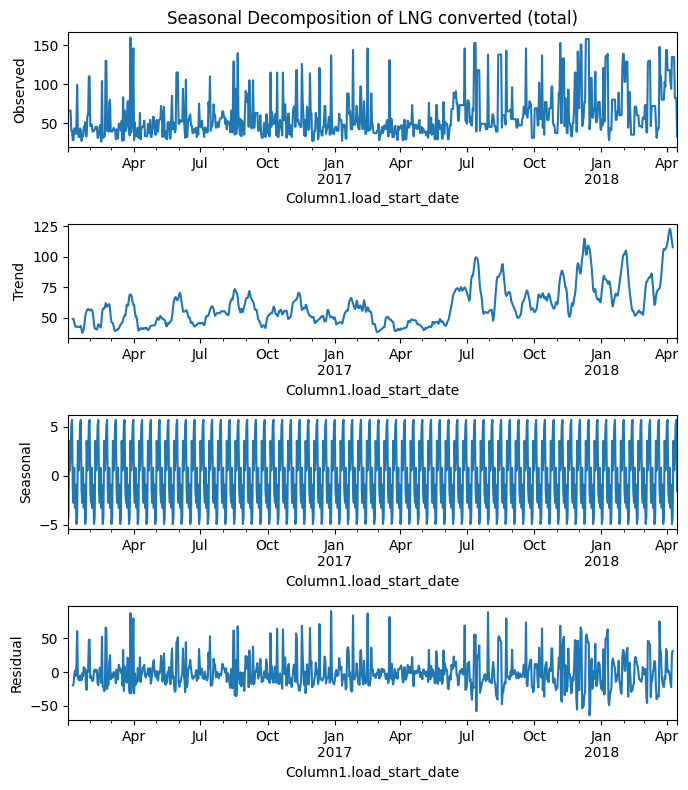

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonality(dataset, period):
    """
    Loop over the columns of a dataset, perform seasonal decomposition on each column,
    and display the results.
    Args:
    - dataset: a pandas DataFrame containing the time series data
    - period: the period of seasonality in the data (default: 12)
    """
    for col in dataset.columns:
        # Convert the column to a time series
        ts = pd.to_datetime(dataset[col])
        
        # Create a decomposition of the time series
        decomp = seasonal_decompose(ts, model='additive', period=period)
        
        # Plot the decomposed time series
        fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(7, 8))
        axes[0].set_title(f"Seasonal Decomposition of {col}")
        decomp.observed.plot(ax=axes[0])
        axes[0].set_ylabel('Observed')
        decomp.trend.plot(ax=axes[1])
        axes[1].set_ylabel('Trend')
        decomp.seasonal.plot(ax=axes[2])
        axes[2].set_ylabel('Seasonal')
        decomp.resid.plot(ax=axes[3])
        axes[3].set_ylabel('Residual')
        plt.tight_layout()
        plt.show()

plot_seasonality(df, 12)

# SMOOTHING OUT THE DATASET, AND COMPARING ORIGINAL VS. SMOOTHED DATASET

In [115]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming dataset is a pandas DataFrame with a single column "s"
# Apply a rolling window to smooth the values with a window size of 3
window_size = 5
smoothed_dataset = df.rolling(window=window_size, center=True).mean()

# Create a single subplot for the original and smoothed values
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, subplot_titles=('Original vs Smoothed'))

# Add traces for the original and smoothed values
fig.add_trace(go.Scatter(x=df.index, y=df['LNG converted (total)'], mode='lines', name='Original'), row=1, col=1)
fig.add_trace(go.Scatter(x=smoothed_dataset.index, y=smoothed_dataset['LNG converted (total)'], mode='lines', name='Smoothed'), row=1, col=1)

# Update plot layout and show the plot
fig.update_layout(title='Smoothed vs Original Data', height=600, width=900)
fig.show()


In [259]:
smoothed_dataset
smoothed_dataset= smoothed_dataset.fillna(smoothed_dataset['LNG converted (total)'].mean())

# SPLITTING DATASET INTO TRAINING AND TESTING DATA

In [261]:
from datetime import datetime,timedelta
train_dataset_end=datetime(2017, 9, 30)
test_dataset_end=datetime(2018,4,15)

train_data=smoothed_dataset[:train_dataset_end]
test_data=smoothed_dataset[train_dataset_end+timedelta(days=1):test_dataset_end]

##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [300]:
train_data

,LNG converted (total)
Column1.load_start_date,
2016-01-02,60.218432
2016-01-03,60.218432
2016-01-04,60.988000
2016-01-05,55.956000
2016-01-06,48.544000
...,...
2017-09-26,65.174000
2017-09-27,57.754000
2017-09-28,48.274000


In [302]:
test_data

,LNG converted (total)
Column1.load_start_date,
2017-10-01,46.286
2017-10-02,53.914
2017-10-03,61.542
2017-10-04,64.868
2017-10-05,60.566
...,...
2018-04-11,114.018
2018-04-12,103.402
2018-04-13,83.040


# APPLYING SARIMAX MODEL

In [264]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data, order=(2,1,1),seasonal_order=(1,1,2,24))

# fit the model to the data
results = model.fit()

# TESTING ON TESTING DATA 

In [307]:
test_data

,LNG converted (total)
Column1.load_start_date,
2017-10-01,46.286
2017-10-02,53.914
2017-10-03,61.542
2017-10-04,64.868
2017-10-05,60.566
...,...
2018-04-11,114.018
2018-04-12,103.402
2018-04-13,83.040


In [308]:
pred=results.predict(start=pred_start_date,end=pred_end_date,dynamic=True)

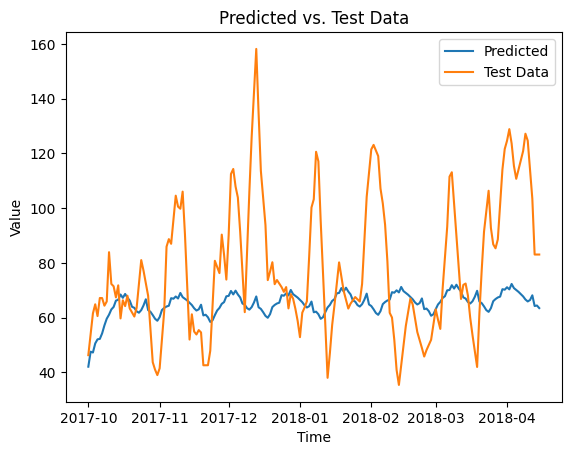

In [309]:
import matplotlib.pyplot as plt

# plot the predicted values
plt.plot(pred, label='Predicted')

# plot the test data
plt.plot(test_data, label='Test Data')

# set the title and labels
plt.title('Predicted vs. Test Data')
plt.xlabel('Time')
plt.ylabel('Value')

# add legend
plt.legend()

# show the plot
plt.show()


# CALCULAING MSE AND RMSE VALUES

In [310]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming y_true and y_pred are the actual and predicted values of the time series, respectively
# Compute the mean squared error (MSE)
mse = mean_squared_error(test_data,pred)

# Compute the root mean squared error (RMSE)
rmse = np.sqrt(mse)

print("RMSE: ", rmse)
print("MSE: ", mse)


RMSE:  27.16250568443418
MSE:  737.8017150569192


# FORECASTING THE FUTURE!

In [311]:
# predict the next 5 values using the fitted model
forecast = results.forecast(steps=4840)

# print the forecasted values
forecast = pd.DataFrame(forecast)


In [313]:
forecast

,predicted_mean
2018-04-16,81.753039
2018-04-17,81.859879
2018-04-18,82.520067
2018-04-19,83.470366
2018-04-20,84.212034
...,...
2031-07-12,311.672575
2031-07-13,310.227543
2031-07-14,308.320681
2031-07-15,306.505692


# PLOTTING THE FORECASTED VALUES

In [271]:
forecast

,predicted_mean
2018-04-16,81.753039
2018-04-17,81.859879
2018-04-18,82.520067
2018-04-19,83.470366
2018-04-20,84.212034
...,...
2031-07-12,311.672575
2031-07-13,310.227543
2031-07-14,308.320681
2031-07-15,306.505692


# PLOTTING FORECAST FOR EVERY DAY UNTIL 2031-07-16

<Axes: >

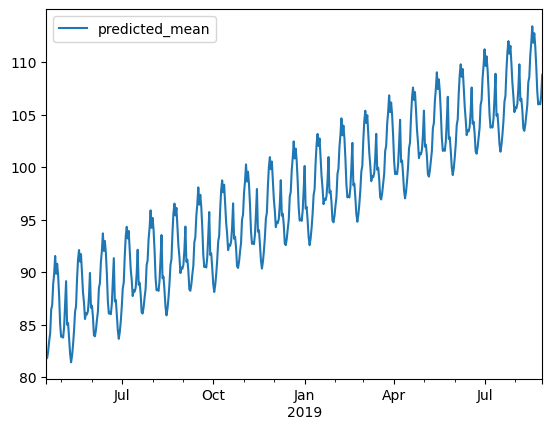

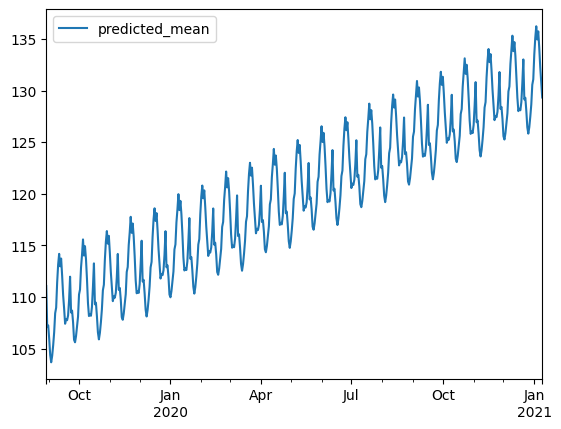

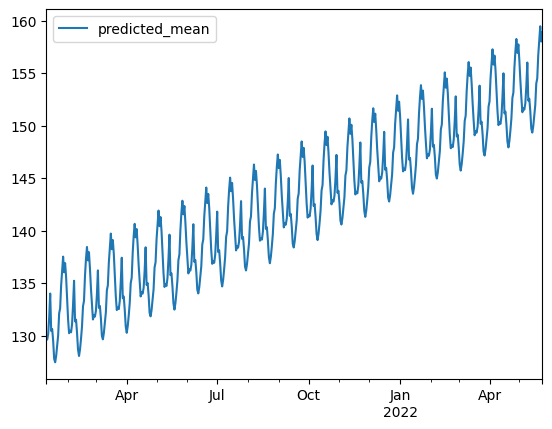

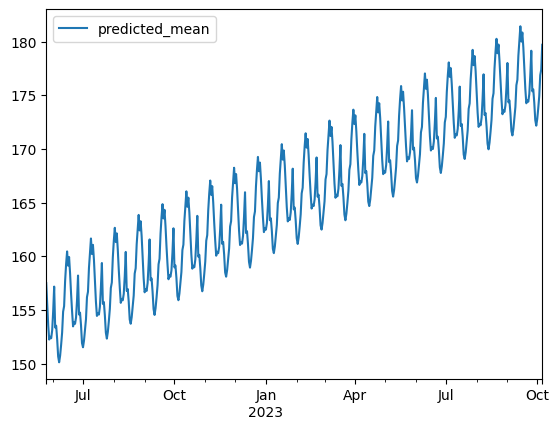

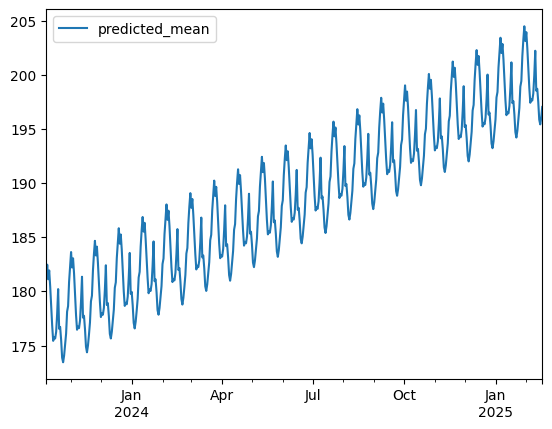

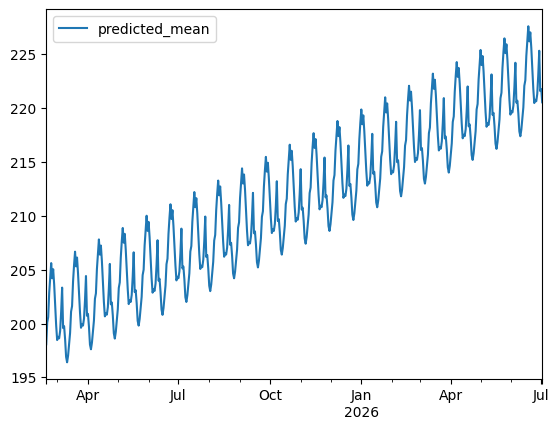

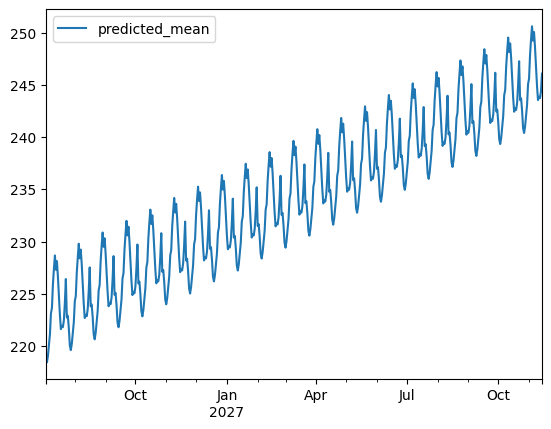

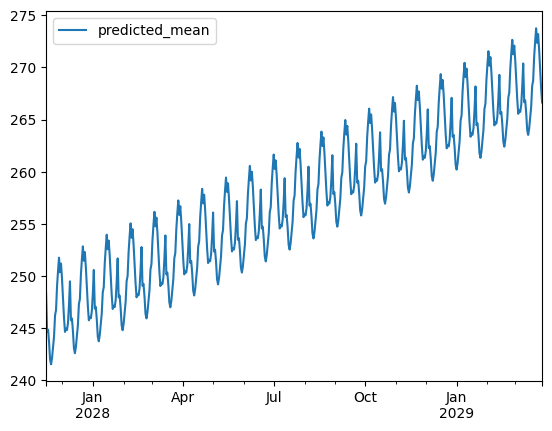

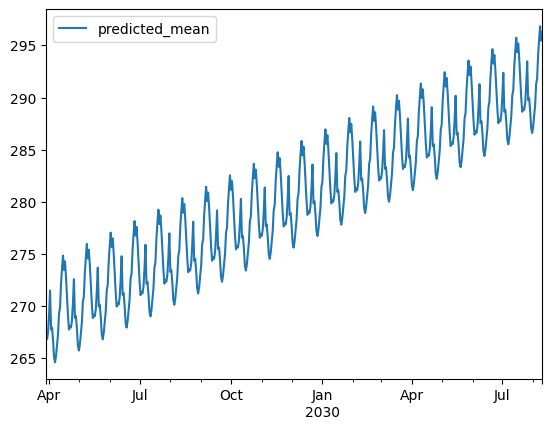

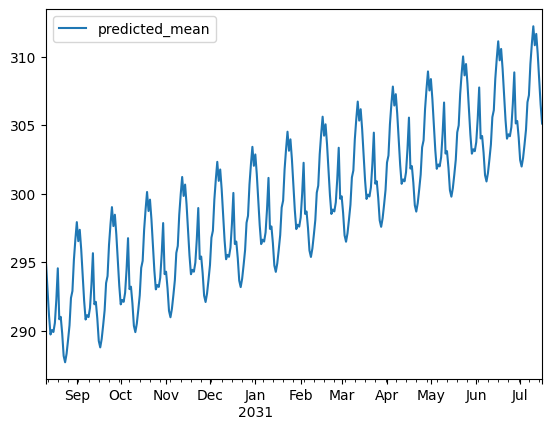

In [272]:
forecast[:500].plot()
forecast[500:1000].plot()
forecast[1000:1500].plot()
forecast[1500:2000].plot()
forecast[2000:2500].plot()
forecast[2500:3000].plot()
forecast[3000:3500].plot()
forecast[3500:4000].plot()
forecast[4000:4500].plot()
forecast[4500:].plot()

# AGGREGATING THE FORECAST INTO YEARLY DATA AND THEN PLOTTING YEARLY PREDICTIONS

In [273]:
df_yearly = forecast.resample('Y').mean()

# Reset the index to include the year as a column
df_yearly = df_yearly.reset_index()

# Extract the year from the datetime index
df_yearly['year'] = pd.DatetimeIndex(df_yearly['index']).year

# Drop the datetime index
df_yearly = df_yearly.drop('index', axis=1)

In [274]:
df_yearly

,predicted_mean,year
0,91.405108,2018
1,105.677428,2019
2,122.405145,2020
3,139.246463,2021
4,155.901278,2022
5,172.621975,2023
6,189.315381,2024
7,206.123550,2025
8,222.880931,2026
9,239.527888,2027


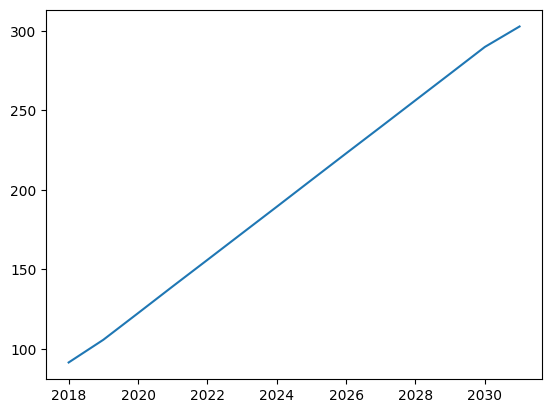

In [275]:
import matplotlib.pyplot as plt
plt.plot(df_yearly['year'], df_yearly['predicted_mean']);